In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np

warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.style.use('seaborn-paper')

%load_ext autoreload
%autoreload 2

from soma.generators.pca import PCAGenerator
from soma.generators.nmist import NmistGenerator
from soma.generators.normal import MultivariateNormalGenerator
from soma.generators.dc2 import DC2Generator
from soma.util.divergence import divergence_vs_dimension
from soma.util.plot import plot_divergences

In [2]:
plot_dir = os.path.expanduser('~/Plots/pca')
os.makedirs(plot_dir, exist_ok=True)

# DC2 MAG Filtered

In [3]:
dc2 = DC2Generator()
dc2_abs = DC2Generator(abs_mag=22)

In [4]:
dc2_dim, dc2_mean, dc2_std, dc2_div = divergence_vs_dimension(dc2, dc2_abs, PCAGenerator)

  0%|          | 0/12 [00:00<?, ?it/s]

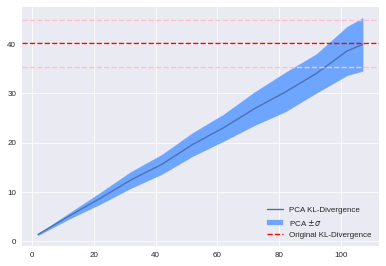

In [5]:
dc2_mag_fig = plt.figure()
plot_divergences(dc2_dim, dc2_div, dc2_mean, dc2_std)
dc2_mag_fig.savefig(os.path.join(plot_dir, 'dc2_mag_divergence.eps'))
dc2_mag_fig.show()

# DC2 SNR

In [6]:
dc2_snr = DC2Generator(snr=10)

In [7]:
dc2_snr_dim, dc2_snr_mean, dc2_snr_std, dc2_snr_div = divergence_vs_dimension(dc2, dc2_snr, PCAGenerator)

  0%|          | 0/12 [00:00<?, ?it/s]

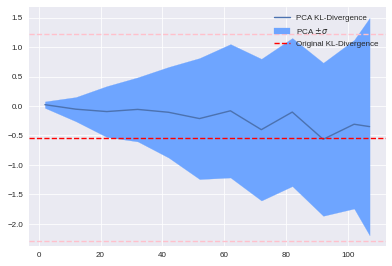

In [8]:
dc2_snr_fig = plt.figure()
plot_divergences(dc2_snr_dim, dc2_snr_div, dc2_snr_mean, dc2_snr_std)
dc2_snr_fig.savefig(os.path.join(plot_dir, 'dc2_snr_divergence.eps'))
dc2_snr_fig.show()

# NMIST

In [9]:
nmist2 = NmistGenerator(2)
nmist3 = NmistGenerator(3)

In [10]:
nmist_dim, nmist_mean, nmist_std, nmist_div = divergence_vs_dimension(nmist2, nmist3, PCAGenerator, step=20)

  0%|          | 0/41 [00:00<?, ?it/s]

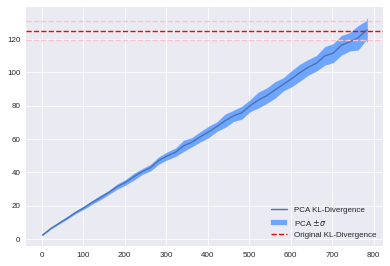

In [11]:
nmist_fig = plt.figure()
plot_divergences(nmist_dim, nmist_div, nmist_mean, nmist_std)
nmist_fig.savefig(os.path.join(plot_dir, 'nmist_divergence.eps'))
nmist_fig.show()

# Normal (location)

In [12]:
means = np.zeros(1000)
means2 = np.ones(1000)

n1 = MultivariateNormalGenerator(means, cov=np.diag(np.ones(1000)))
n2 = MultivariateNormalGenerator(means2, cov=np.diag(np.ones(1000)))

In [13]:
normal_dim, normal_mean, normal_std, normal_div = divergence_vs_dimension(n1, n2, PCAGenerator, step=50)

  0%|          | 0/21 [00:00<?, ?it/s]

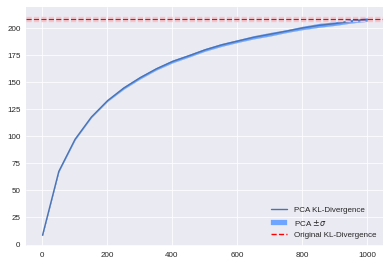

In [14]:
norm_loc111_fig = plt.figure()
plot_divergences(normal_dim, normal_div, normal_mean, normal_std)
norm_loc111_fig.savefig(os.path.join(plot_dir, 'normal_111_divergence.eps'))
norm_loc111_fig.show()

# Normal (location, fair)

In [15]:
means3 = np.zeros(1000)
means2[0] = 1.

n3 = MultivariateNormalGenerator(means3, cov=np.diag(np.ones(1000)))

In [16]:
_, n3_mean, n3_std, n3_div = divergence_vs_dimension(n1, n3, PCAGenerator, step=50)

  0%|          | 0/21 [00:00<?, ?it/s]

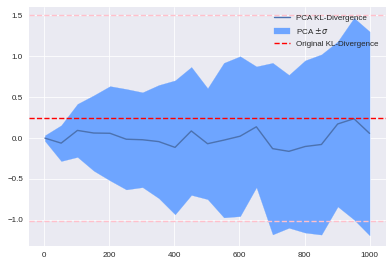

In [17]:
norm_fair_fig = plt.figure()
plot_divergences(normal_dim, n3_div, n3_mean, n3_std)
norm_fair_fig.savefig(os.path.join(plot_dir, 'normal_fair_divergence.eps'))
norm_fair_fig.show()

# Normal (scale)

In [18]:
ns1 = MultivariateNormalGenerator(means, wishart_df=len(means)+1)
ns2 = MultivariateNormalGenerator(means, wishart_df=len(means)+1)

In [19]:
_, ns_mean, ns_std, ns_div = divergence_vs_dimension(ns1, ns2, PCAGenerator, step=50)

  0%|          | 0/21 [00:00<?, ?it/s]

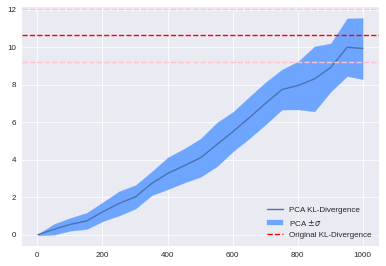

In [20]:
norm_scale_fig = plt.figure()
plot_divergences(normal_dim, ns_div, ns_mean, ns_std)
norm_scale_fig.savefig(os.path.join(plot_dir, 'normal_scale_divergence.eps'))
norm_scale_fig.show()